In [1]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl

In [2]:
from HEPAutoencoders.nn_utils import AE_big, AE_3D_200
from HEPAutoencoders.utils import plot_activations

In [3]:
torch.cuda.is_available()

False

In [4]:
#fastai.torch_core.defaults.device = 'cuda'

In [5]:
from HEPAutoencoders.pre_processing import process_root_leading

branchnames = ['HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.m',
               'HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.pt',
               'HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.phi',
               'HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.eta']

"""
May be
branchnames = ['AntiKt4EMTopoJetsAux.m',
               'AntiKt4EMTopoJetsAux.pt',
               'AntiKt4EMTopoJetsAux.phi',
               'AntiKt4EMTopoJetsAux.eta']
in some datasets
"""

# Load data
train, test = process_root_leading("DAOD_TRIG6.16825104._000230.pool.root.1", branchnames)

n_features = len(train.loc[0])

train = train.sample(frac=1)
test = test.sample(frac=1)

train.head(10)

Reading: HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.m
Reading: HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.pt
Reading: HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.phi
Reading: HLT_xAOD__JetContainer_TrigHLTJetDSSelectorCollectionAuxDyn.eta
Creating (flattened) DataFrame of leading events...
Head of data:
             m             pt       phi       eta
0  8298.433594   90167.523438  1.535709  0.945709
1  7230.861816   73501.625000  0.305171 -0.279906
2  8883.339844   86142.484375 -1.587625  1.877115
3  8949.270508  115326.023438 -2.948715  0.831543
4  6370.583008  105564.234375  2.382645  2.381205


,m,pt,phi,eta
1763062,9052.409180,86456.960938,2.020386,-1.941420
1185230,11128.014648,91175.421875,1.531428,-1.728243
998869,8313.961914,95736.804688,2.277138,1.361068
1426045,5445.075195,116647.437500,-0.911312,-1.594110
467824,10032.022461,86872.093750,-2.861285,-1.905899
1469859,12836.355469,92617.164062,-2.820247,-1.115655
1132447,4511.261230,69133.320312,-1.591048,0.177063
1708191,15489.120117,91179.750000,1.866568,0.905254
982635,8374.075195,89821.593750,-1.522815,1.690220
437642,9280.160156,87343.156250,1.090649,0.217729


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


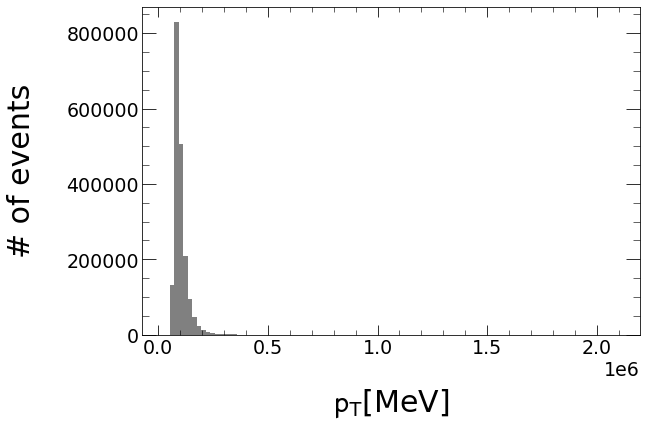

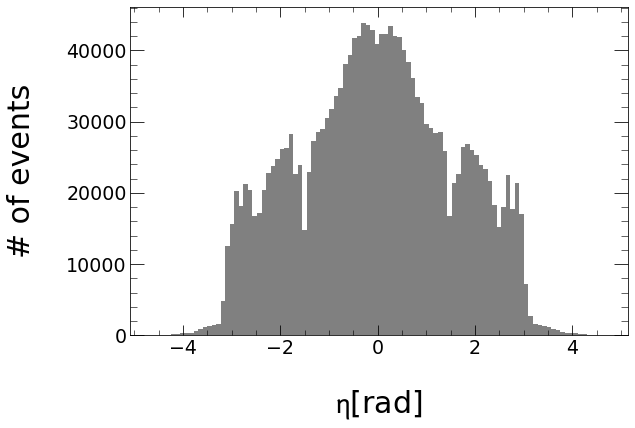

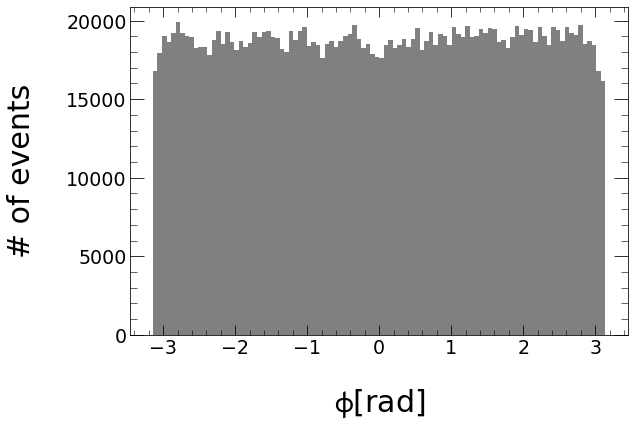

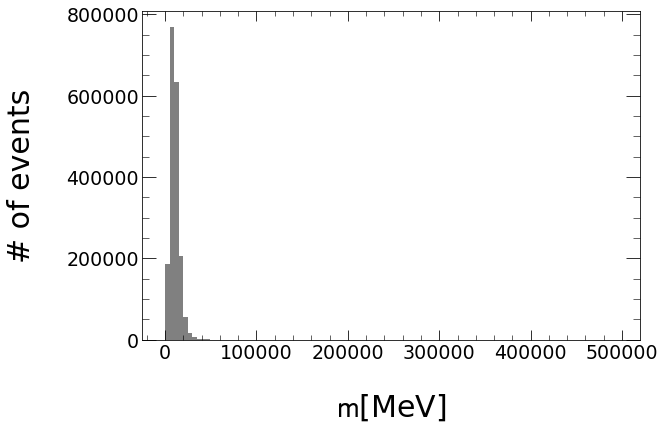

In [6]:
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ATLAS)

unit_list = ['[MeV]', '[rad]', '[rad]', '[MeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']

branches=["pt","eta","phi","m"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_"+branches[kk],dpi=300)
    plt.show()

In [7]:
# Normalize

eta_div = 5
phi_div = 3
m_div = 1.8
m_add = 1
pt_div = 1.2
pt_sub = 1.3

#Remove zero mass jets
train = train.loc[train["m"] > 0.08]
test = test.loc[test["m"] > 0.08]

for data in [train,test]:
    data['eta'] = data['eta'] / eta_div
    data['phi'] = data['phi'] / phi_div
    data['m'] = np.log10(data['m'] + m_add) / m_div - 2
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div - 3

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

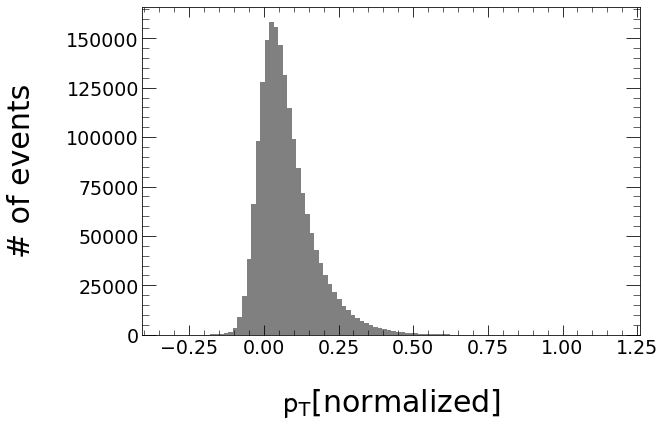

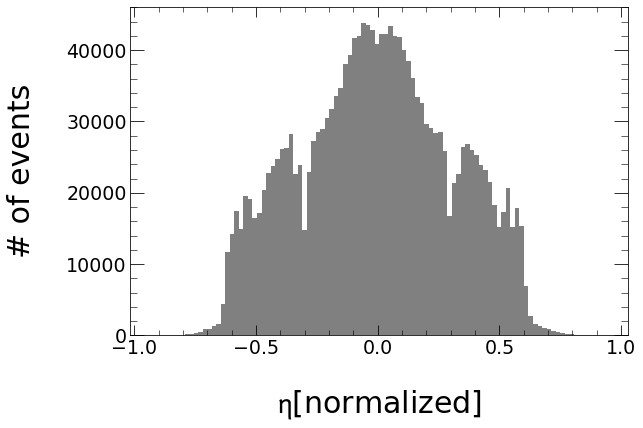

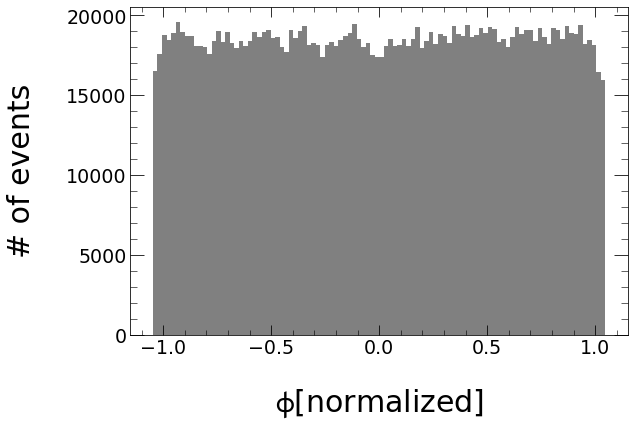

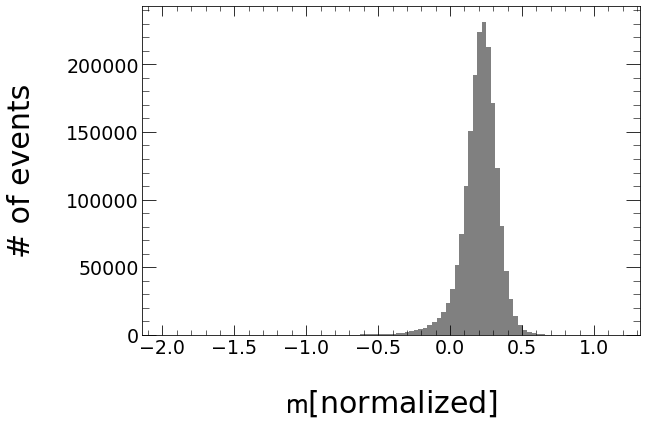

In [8]:
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ATLAS)

unit_list = ['[normalized]', '[normalized]', '[normalized]', '[normalized]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']

branches=["pt","eta","phi","m"]

n_bins = 100

for kk in range(0,4):
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color='gray', label='Input', alpha=1, bins=n_bins)
    plt.xlabel(xlabel=variable_list[kk] + unit_list[kk])
    plt.ylabel('# of events')
    #plt.savefig("fourmomentum_normalized_"+branches[kk],dpi=300)
    plt.show()

In [9]:
from HEPAutoencoders.utils import get_data_loader

train_dl, valid_dl = get_data_loader(train_ds, valid_ds, bs=256)

In [10]:
db = basic_data.DataBunch(train_dl, valid_dl)

In [11]:
class AE_3D_200_LeakyReLU(nn.Module):
    def __init__(self, n_features=4):
        super(AE_3D_200_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 200)
        self.en2 = nn.Linear(200, 200)
        self.en3 = nn.Linear(200, 20)
        self.en4 = nn.Linear(20, 3)
        self.de1 = nn.Linear(3, 20)
        self.de2 = nn.Linear(20, 200)
        self.de3 = nn.Linear(200, 200)
        self.de4 = nn.Linear(200, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-100-50-3-50-100-200-out'

model = AE_3D_200_LeakyReLU().double()

In [12]:
loss_func = nn.MSELoss()

bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd = 1e-6
#wd = 0
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

In [ ]:
#from fastai import train as tr
#tr.lr_find(learn)

In [ ]:
#learn.recorder.plot()

In [ ]:
"""
lr = 1e-3
learn.fit(10, lr=lr, wd=wd)

lr = 1e-4
learn.fit(50, lr=lr, wd=wd)

lr = 1e-5
learn.fit(100, lr=lr, wd=wd)

lr = 1e-6
learn.fit(100, lr=lr, wd=wd)

learn.save("4D_TLA_leading")
"""

In [13]:
learn.load("4D_TLA_leading")
learn.validate()

[0.0005074535248253798]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 630x426.24 with 0 Axes>

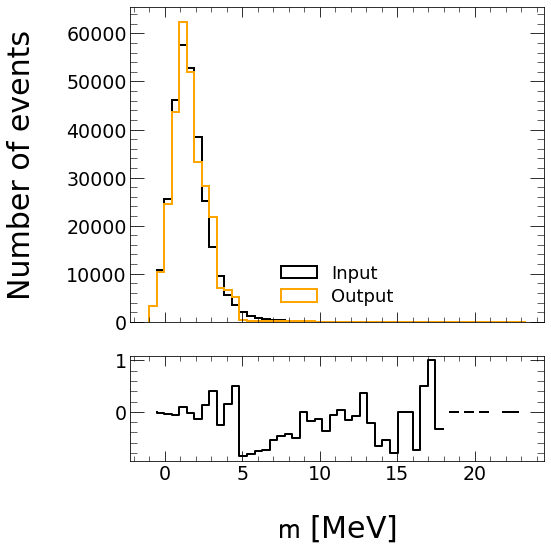

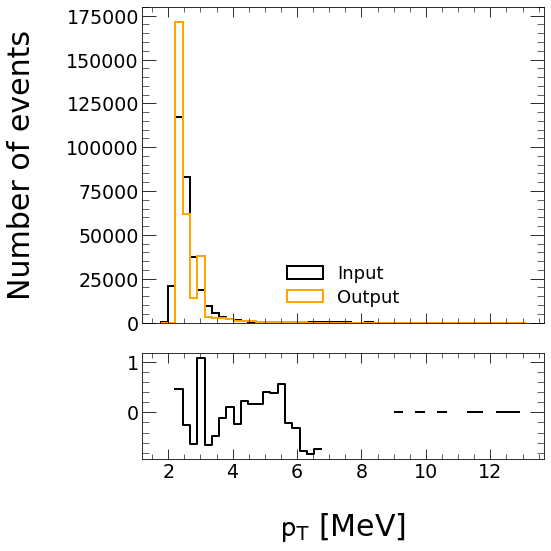

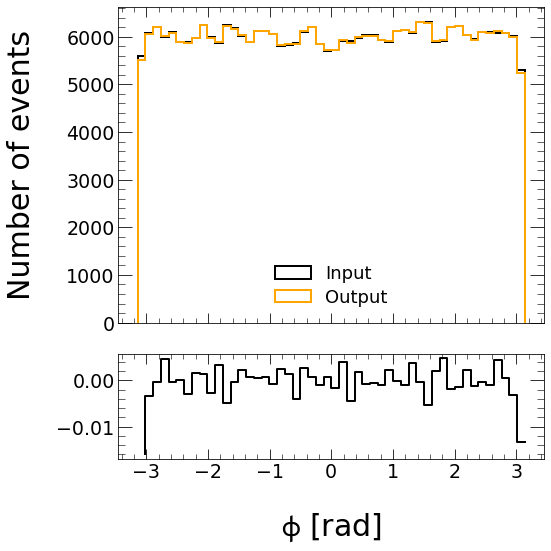

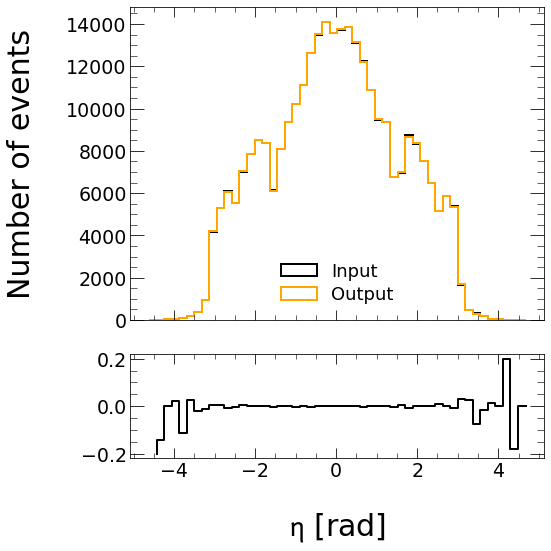

In [14]:
plt.close('all')
unit_list = ['[MeV]', '[MeV]', '[rad]', '[rad]']
variable_list = [r'$m$', r'$p_T$', r'$\phi$', r'$\eta$']
line_style = ['--', '-']
colors = ['orange', 'black']
markers = ['*', 's']

model.to('cpu')

learn.load('4D_TLA_leading')

# Histograms
idxs = (0, 300000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
pred = model(data).detach().numpy()

#Un-normalization
for d in [data,pred]:
    d[:, 3] = d[:, 3] * eta_div
    d[:, 2] = d[:, 2] * phi_div
    d[:, 0] = np.power(10,d[:, 0] * m_div)-m_add
    d[:, 1] = np.power(10,d[:, 1] * pt_div)+pt_sub

def getRatio(bin1,bin2):
    bins = []
    for b1,b2 in zip(bin1,bin2):
        if b1==0 and b2==0:
            bins.append(0.)
        elif b2==0:
            bins.append(None)
        else:
            bins.append((float(b2)-float(b1))/b1)
    return bins    
    
alph = 0.8
n_bins = 50
for kk in [0,1,2,3]:
    plt.figure(kk + 4)
    fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8),gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    n_hist_data, bin_edges, _ = ax1.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins, histtype="step",linewidth=2)
    n_hist_pred, _, _ = ax1.hist(pred[:, kk], color=colors[0], label='Output', alpha=1, bins=bin_edges, histtype='step',linewidth=2)
    plt.xlabel(variable_list[kk] + ' ' + unit_list[kk])
    ax1.set(ylabel='Number of events')
    ax1.legend(loc=8)
    
    rat = getRatio(n_hist_data,n_hist_pred)
    ax2.step(bin_edges[1:],rat, color='black',linewidth=2)
    plt.tight_layout()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    #plt.savefig("TLA_histogram_" + train_x.columns[kk])

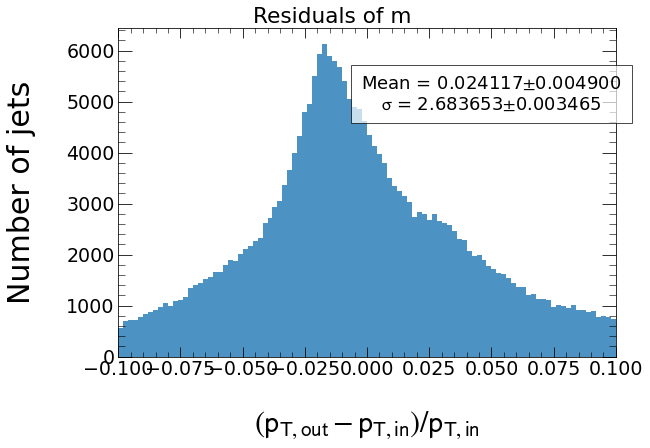

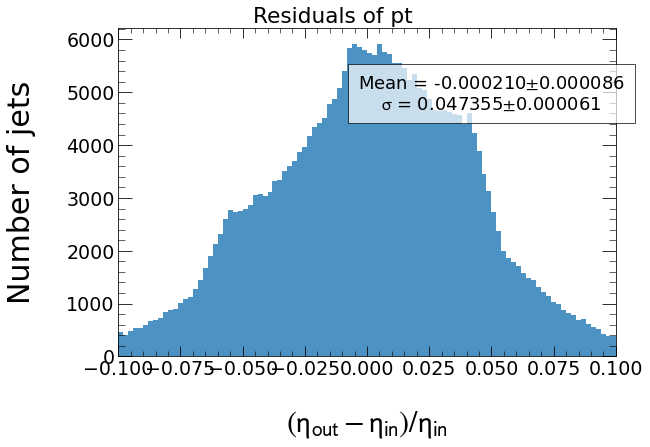

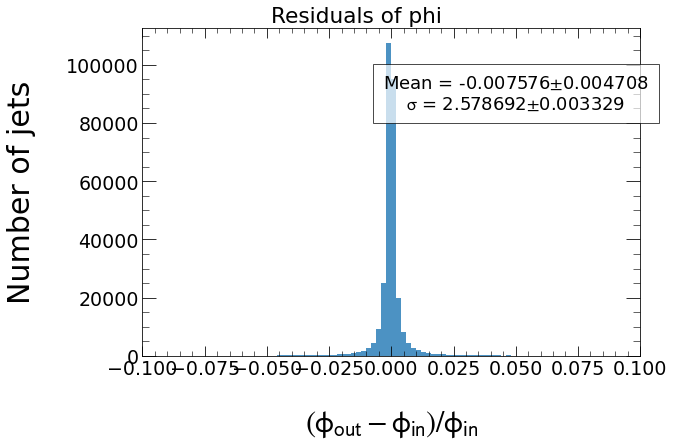

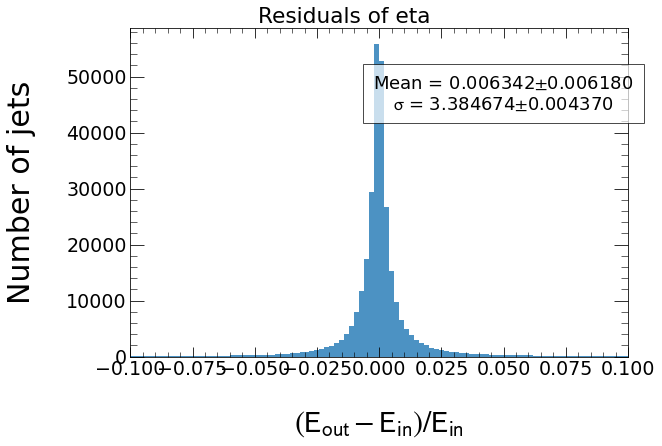

In [16]:
import HEPAutoencoders.utils as utils
from scipy import stats
residual_strings = [r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$',
                        r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(E_{out} - E_{in}) / E_{in}$']
residuals = (pred - data.detach().numpy()) / data.detach().numpy()
axisrange = (-.1, .1)

for kk in np.arange(4):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=100, range=axisrange)
    plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    plt.xlim(axisrange)
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = 'trainforever_residual_%s' % train.columns[kk]
    #plt.savefig(curr_save_folder + fig_name)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


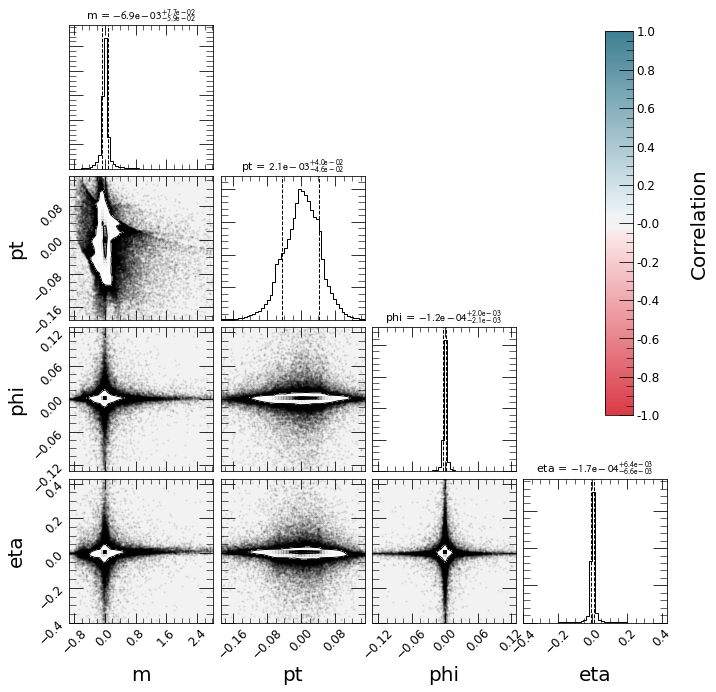

In [17]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'m': residuals[:, 0], 'pt': residuals[:, 1], 'phi': residuals[:, 2], 'eta': residuals[:, 3]})
save = False

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['m', 'pt', 'phi', 'eta']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3d.png'
    plt.savefig('TLA_' + fig_name)